In [1]:
%matplotlib widget

In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_HEIGHT, IMG_WIDTH = 224, 304
BATCH_SIZE = 32
BASE_DIR = 'nyu_data/data'


In [3]:
def parse_csv(csv_path):
    df = pd.read_csv(csv_path, header=None)
    color_paths = df[0].tolist()
    depth_paths = df[1].tolist()
    return color_paths, depth_paths

def get_valid_path(base_dir, rel_path):
    if base_dir.endswith('data') and rel_path.startswith('data/'):
        rel_path = rel_path[len('data/'):]
    return os.path.normpath(os.path.join(base_dir, rel_path))

def load_image(path):
    img = Image.open(path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img).astype(np.float32) / 255.0
    return img

def load_depth(path):
    depth = Image.open(path).resize((IMG_WIDTH, IMG_HEIGHT))
    depth = np.array(depth).astype(np.float32)
    if np.max(depth) > 0:
        depth = depth / np.max(depth)
    depth = depth[..., np.newaxis]
    return depth

def dataset_generator(color_paths, depth_paths, base_dir):
    subset_size = 5000  # Limit to 5,000 images
    for color_rel, depth_rel in zip(color_paths[:subset_size], depth_paths[:subset_size]):
        color_path = get_valid_path(base_dir, color_rel)
        depth_path = get_valid_path(base_dir, depth_rel)
        if not os.path.isfile(color_path) or not os.path.isfile(depth_path):
            continue
        img = load_image(color_path)
        depth = load_depth(depth_path)
        yield img, depth

def create_tf_dataset(color_paths, depth_paths, base_dir):
    dataset = tf.data.Dataset.from_generator(
        lambda: dataset_generator(color_paths, depth_paths, base_dir),
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 1), dtype=tf.float32),
        ),
    )
    return dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_csv = os.path.join(BASE_DIR, 'nyu2_train.csv')
val_csv = os.path.join(BASE_DIR, 'nyu2_test.csv')
train_color_paths, train_depth_paths = parse_csv(train_csv)
val_color_paths, val_depth_paths = parse_csv(val_csv)
train_dataset = create_tf_dataset(train_color_paths, train_depth_paths, BASE_DIR)
val_dataset = create_tf_dataset(val_color_paths, val_depth_paths, BASE_DIR)

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, Input

base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
]
layers = [base_model.get_layer(name).output for name in layer_names]
encoder = Model(inputs=base_model.input, outputs=layers)

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
skips = encoder(inputs)
x = skips[-1]
x = Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(x)
x = Concatenate()([x, skips[-2]])
x = Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
x = Concatenate()([x, skips[-3]])
x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
x = Concatenate()([x, skips[-4]])
x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
outputs = Conv2D(1, 1, padding='same', activation='linear')(x)
outputs = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)))(outputs)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_pretrained_model.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
]

TOTAL_EPOCHS = 10

model.load_weights('best_pretrained_model.h5')

# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=TOTAL_EPOCHS,
#     initial_epoch=8,
#     callbacks=callbacks
# )


C:\Users\Deepak\AppData\Local\Temp\ipykernel_5628\1236666722.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 304, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ [(None, 112, 152, 96),    │         616,256 │ input_layer_1[0][0]        │
│                               │ (None, 56, 76, 144),      │                 │                            │
│                               │ (None, 28, 38, 192),      │                 │                            │
│                               │ (None, 14, 19, 576)]      │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 28, 38, 512)       │       2,654,720 │ functional[0][3]           │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 28, 38, 704)       │               0 │ conv2d_transpose[0][0],    │
│                               │                           │                 │ functional[0][2]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_1            │ (None, 56, 76, 256)       │       1,622,272 │ concatenate[0][0]          │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 56, 76, 400)       │               0 │ conv2d_transpose_1[0][0],  │
│                               │                           │                 │ functional[0][1]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_2            │ (None, 112, 152, 128)     │         460,928 │ concatenate_1[0][0]        │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 112, 152, 224)     │               0 │ conv2d_transpose_2[0][0],  │
│                               │                           │                 │ functional[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_3            │ (None, 224, 304, 64)      │         129,088 │ concatenate_2[0][0]        │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 224, 304, 1)       │              65 │ conv2d_transpose_3[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 224, 304, 1)       │               0 │ conv2d[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 5,483,329 (20.92 MB)

 Trainable params: 5,466,049 (20.85 MB)

 Non-trainable params: 17,280 (67.50 KB)

In [5]:
def resize_output(x):
    import tensorflow as tf
    return tf.image.resize(x, (224, 304))


outputs = tf.keras.layers.Lambda(
    resize_output,
    output_shape=(224, 304, 1)  
)(outputs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


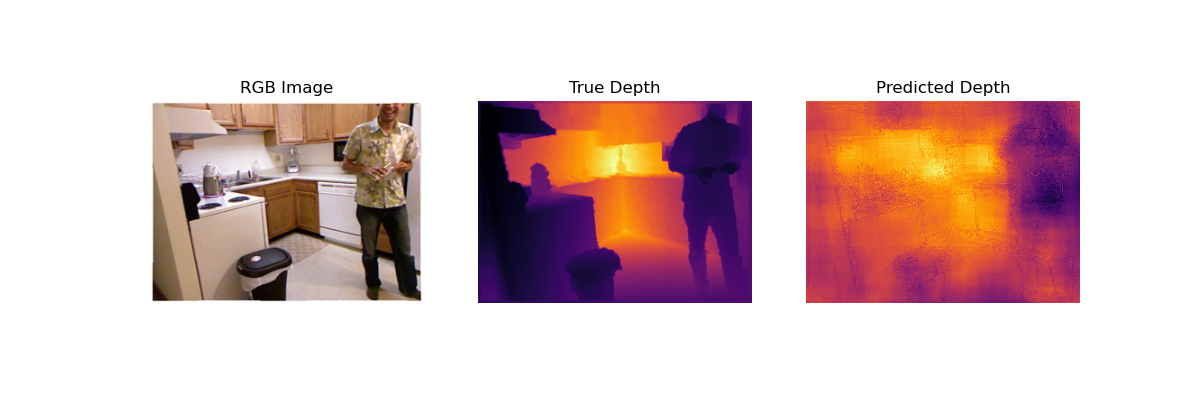

Average depth in region: 0.7844870686531067


In [6]:
# Visualize predictions
for img_batch, depth_batch in val_dataset.take(1):
    preds = model.predict(img_batch)
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.imshow(img_batch[0])
    plt.title('RGB Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(depth_batch[0].numpy().squeeze(), cmap='inferno')
    plt.title('True Depth')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(preds[0].squeeze(), cmap='inferno')
    plt.title('Predicted Depth')
    plt.axis('off')
    plt.show()
    break

def region_depth(depth_map, region):
    (r1, c1), (r2, c2) = region
    return float(np.mean(depth_map[r1:r2, c1:c2]))

sample_pred = preds[0].squeeze()
region = ((50, 60), (150, 180))
avg_depth = region_depth(sample_pred, region)
print('Average depth in region:', avg_depth)


In [7]:
def preprocess_image(path):
    img = Image.open(path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT))
    arr = np.array(img).astype(np.float32) / 255.0
    return arr


image_path = 'images.jpeg'  
rgb = preprocess_image(image_path)
input_img = np.expand_dims(rgb, axis=0)


pred_depth = model.predict(input_img)[0].squeeze()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


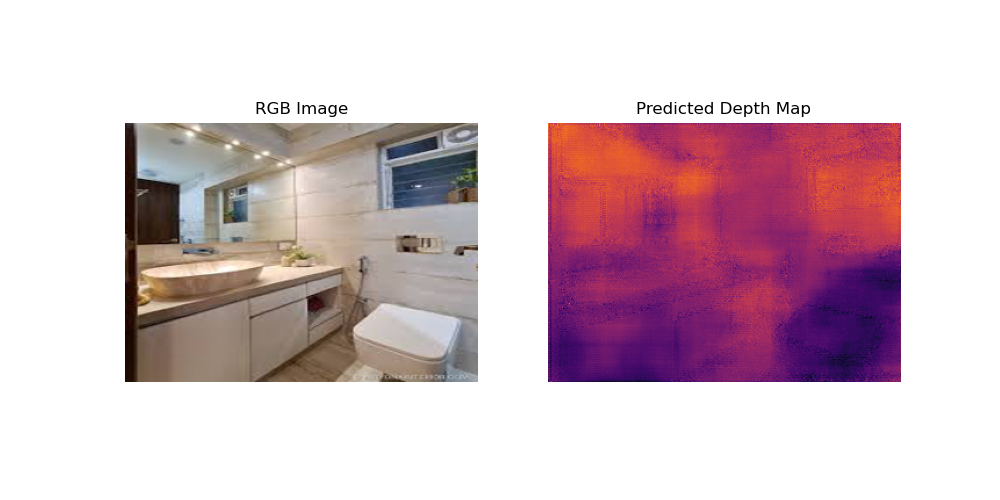

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(rgb)
axes[0].set_title('RGB Image')
axes[0].axis('off')
axes[1].imshow(pred_depth, cmap='inferno')
axes[1].set_title('Predicted Depth Map')
axes[1].axis('off')
plt.show()
